# **Why do people leave Salifort Motors?**




## Description and deliverables

My name is Maciek Uzdrzychowski and I'll share the capstone project that I made for the Google Advanced Data Analytics course at coursera.org. I am going to analyze HR data (which can be found [here](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv)) to predict the behaviour of the employees of Salifort Motors company.

To answer the business question I will do EDA and I'll build 4 models (binomial logistic regression, tree-based and 2 random forest models).

Note that this is 2nd iteration of the project based on feedback that I received after finishing the course. During the first iterations, I made a few mistakes and I didn't include a few functions, charts and ideas. I want to be very clear about that.
So what's changed in ver2?
- checking every variable for outliers (not only 2)
- added plots for: "Avg monthly hrs histogram", "monthly hours vs number of projects", "monthly hours look vs satisfaction level"
- added functions: "make_results", "read_pickle", "write_pickle"
- including a drop of the column "satisfaction_level" during feature engineering

What can be done better in future?
- use XGBost
- split the data into 3 buckets - adding split into a validation set


Below you can find the ver2

# **PACE framework**


When it comes to process of my analysis I will follow the Google's PACE framework

<div>
<center><img src="pace.png" width="300"/></center>
</div>

Here are some example activities under each step:

1. Plan:
Research business data, Define the project scope, Develop a workflow, Assess project and/or stakeholder needs, Analyze

2. Analyze:
Format database, Scrub data, Convert data into usable formats, Construct

3. Construct:
Select modeling approach, Build models, Build machine learning algorithms, Execute

4. Execute:
Share results, Present findings to other stakeholders, Address feedback

### Business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They have the following question: <b>what’s likely to make the employee leave the company?</b>

The goals of this project are to <b>analyze the data</b> collected by the HR department and to <b>build a model</b> that predicts whether or not an employee will leave the company. 

It might be possible to identify factors that contribute to employees' leaving. Because it is time consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### First look at the dataset 


In this dataset, there are 14,999 rows, 10 columns, and these variables: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)


Ok let's dive into work

## Step 1. Imports




### Import packages

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import pickle

### Load dataset

In [118]:
df_original = pd.read_csv("HR_comma_sep.csv")
df_original.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


Ok, so far so good. The data is ready to work on.

## Step 2. EDA and cleaning

Let's see what we have here and let's check for missing values, outliers, duplicates (and what to do with them).

At first we are going to gather some statics information about given dataset:

In [119]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB



**There is no single null in the data. Nice**

In [120]:
df_original.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Ok, what we have here:
- satisfaction_level - mean is different than median
- number_project - it is just gut feeling but anything above 2 projects at the same time for an employee doesn't seem to be optimal in terms of performance and happiness (7 is max :O )
- average_monthly_hours should be around 160hours (8h*5days*4weeks) while the mean and median are at 200 and the max at 310, we need to take a look at what is happening in this company
- work_accident, left, promotion_last_5years - since they are boolean let's look at their proportions:
- no infinities - one step less in feature engineering

In [121]:
print("Work accident proportion:\n",df_original['Work_accident'].value_counts(normalize=True))
print("\nDid emplyee left? proportion\n",df_original['left'].value_counts(normalize=True))
print("\nPromotion last 5 years proportion:\n",df_original['promotion_last_5years'].value_counts(normalize=True))

Work accident proportion:
 0    0.85539
1    0.14461
Name: Work_accident, dtype: float64

Did emplyee left? proportion
 0    0.761917
1    0.238083
Name: left, dtype: float64

Promotion last 5 years proportion:
 0    0.978732
1    0.021268
Name: promotion_last_5years, dtype: float64


- 14,5% of employees had an accident at work
- almost 24% left 
- only 2% of all employees have been promoted during the last 5 years, that's weird

### Cleaning

Ok, it's time for cleaning. Column names don't seem to follow any particular rules so let's tweak that:

In [122]:
df_original.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [123]:
df_original = df_original.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})
df_original.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

In [124]:
df_original.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

No missing values here.

### Check duplicates

In [125]:
df_original.duplicated().sum()

3008

3_008 rows with duplicates. That's around 1/5

It's always good to consider duplicated data in context.
The context is that: how likely is it that two different employees in the same company generated identical data? Not very likely. We'll need more information from the business person for one.
For now, I'm going to delete duplicates.

In [126]:
df1 = df_original.drop_duplicates(keep='first')
#df1.head()

### Check outliers

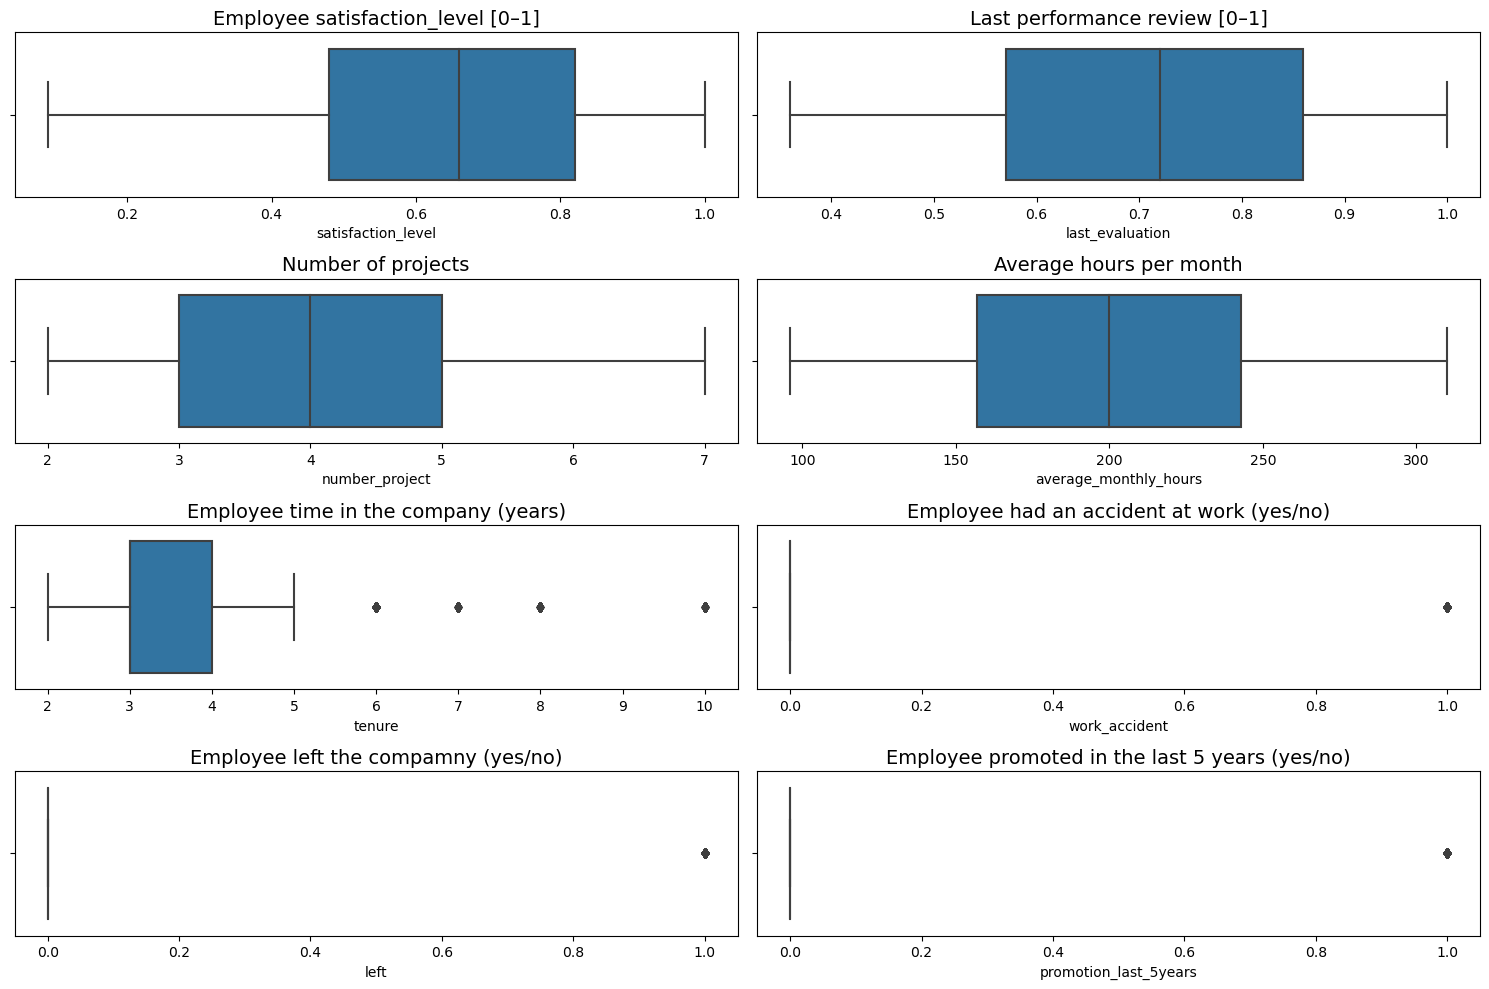

In [127]:
fig, ax = plt.subplots(4, 2, figsize = (15,10))


sns.boxplot(x=df1['satisfaction_level'], ax=ax[0,0])
ax[0,0].set_title('Employee satisfaction_level [0–1]', fontsize='14')

sns.boxplot(x=df1['last_evaluation'], ax=ax[0,1])
ax[0,1].set_title('Last performance review [0–1]', fontsize='14')

sns.boxplot(x=df1['number_project'], ax=ax[1,0])
ax[1,0].set_title('Number of projects', fontsize='14')

sns.boxplot(x=df1['average_monthly_hours'], ax=ax[1,1])
ax[1,1].set_title('Average hours per month', fontsize='14')

sns.boxplot(x=df1['tenure'], ax=ax[2,0])
ax[2,0].set_title('Employee time in the company (years)', fontsize='14')

sns.boxplot(x=df1['work_accident'], ax=ax[2,1])
ax[2,1].set_title('Employee had an accident at work (yes/no)', fontsize='14')

sns.boxplot(x=df1['left'], ax=ax[3,0])
ax[3,0].set_title('Employee left the compamny (yes/no)', fontsize='14')

sns.boxplot(x=df1['promotion_last_5years'], ax=ax[3,1])
ax[3,1].set_title('Employee promoted in the last 5 years (yes/no)', fontsize='14')

fig.tight_layout()
plt.show()

Ok, looking for outliers in boolean data wasn't the smartest idea, however, we see that outliers do appear for time employees spend in the company (tenure).

Let's see how many outliers in 'tenure' we have:

In [128]:
percent25 = df1['tenure'].quantile(0.25)
percent75 = df1['tenure'].quantile(0.75)

iqr = percent75 - percent25

upper_limit = percent75 + 1.5 * iqr
lower_limit = percent25 - 1.5 * iqr

outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Total number of rows in 'tenure':", len(df1['tenure']))
print("Number of outliers:", len(outliers))

prop = (len(outliers) / len(df1['tenure']))
print(f"\n% of outliers: {prop*100:.2f}")

Total number of rows in 'tenure': 11991
Number of outliers: 824

% of outliers: 6.87


Ok. When we get to choosing the model we need to be aware of the above outliers if we choose to proceed with logistic regression. One of the logistic regression assumptions is "no extreme outliers". 

## Step 2. Data Exploration (Continue EDA)

Work smart, not hard. Let's use correlation heatmap to get a hint where to look for correlated data.


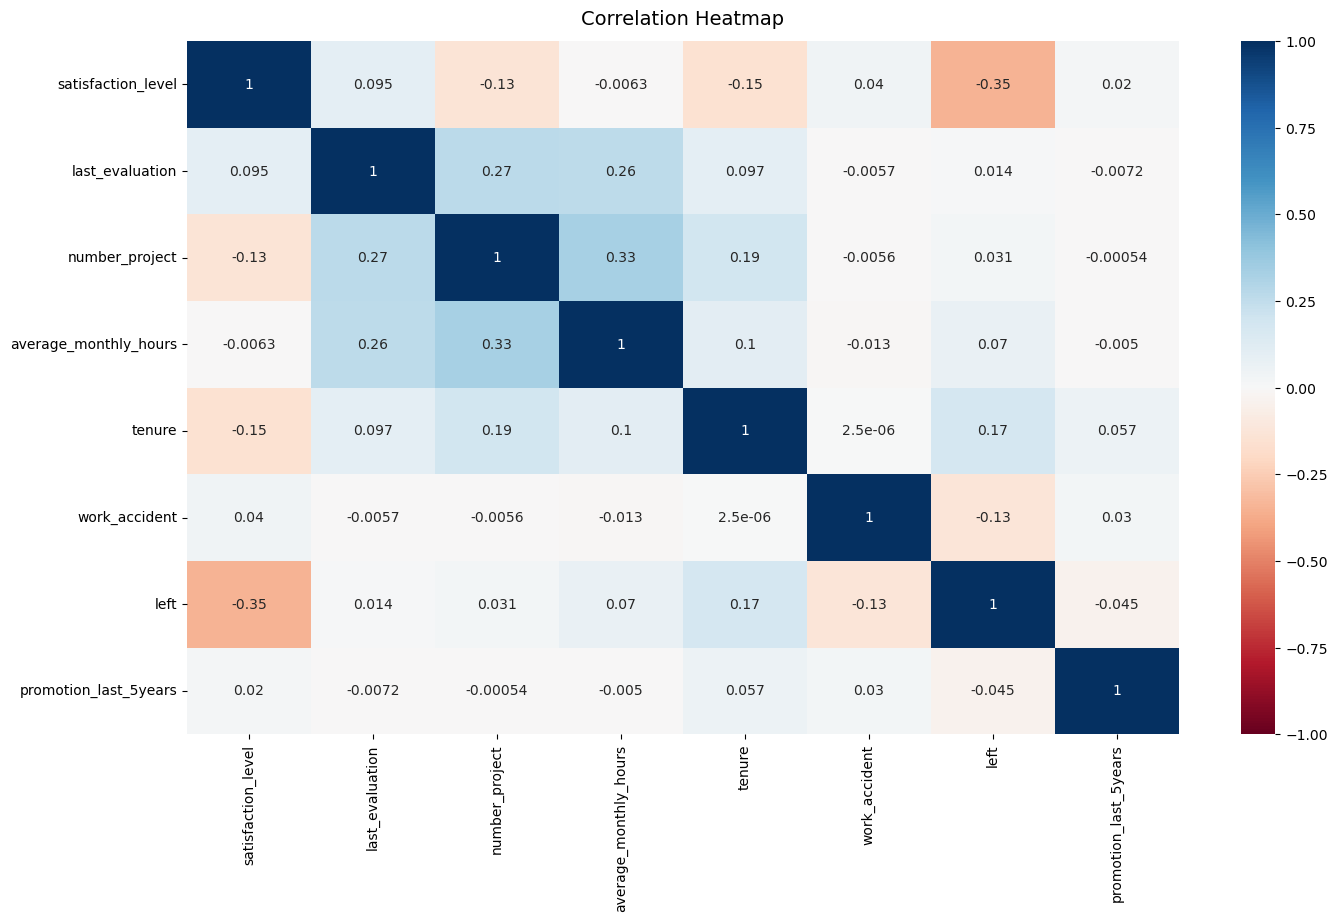

In [129]:
#removing non-numeric columns to avoid warning
df_corr = df1.drop(['department', 'salary'], axis=1)


plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("RdBu", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);


Aha. Leaving the company is negatively correlated with employee satisfaction level. That's not a surprise.

Additionally: last evaluation, the number of projects and monthly hours are correlated with one another in some way.

Let's use those hints to dig deeper, but first keep in mind a very important saying:

<div>
<center><img src="duck.png" width="300"/></center>
</div>

### Data visualizations

As first take a look at the obvious: leaving the company vs satisfaction level. Is there a difference between those two groups?

In [130]:
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


The mean and median are higher for employees who stayed - not a surprise.
In both cases mean is slightly different than the median. It means that data might be skewed.

How last evaluation, number of projects, monthly hours and tenure look after split into those who left and stayed? 

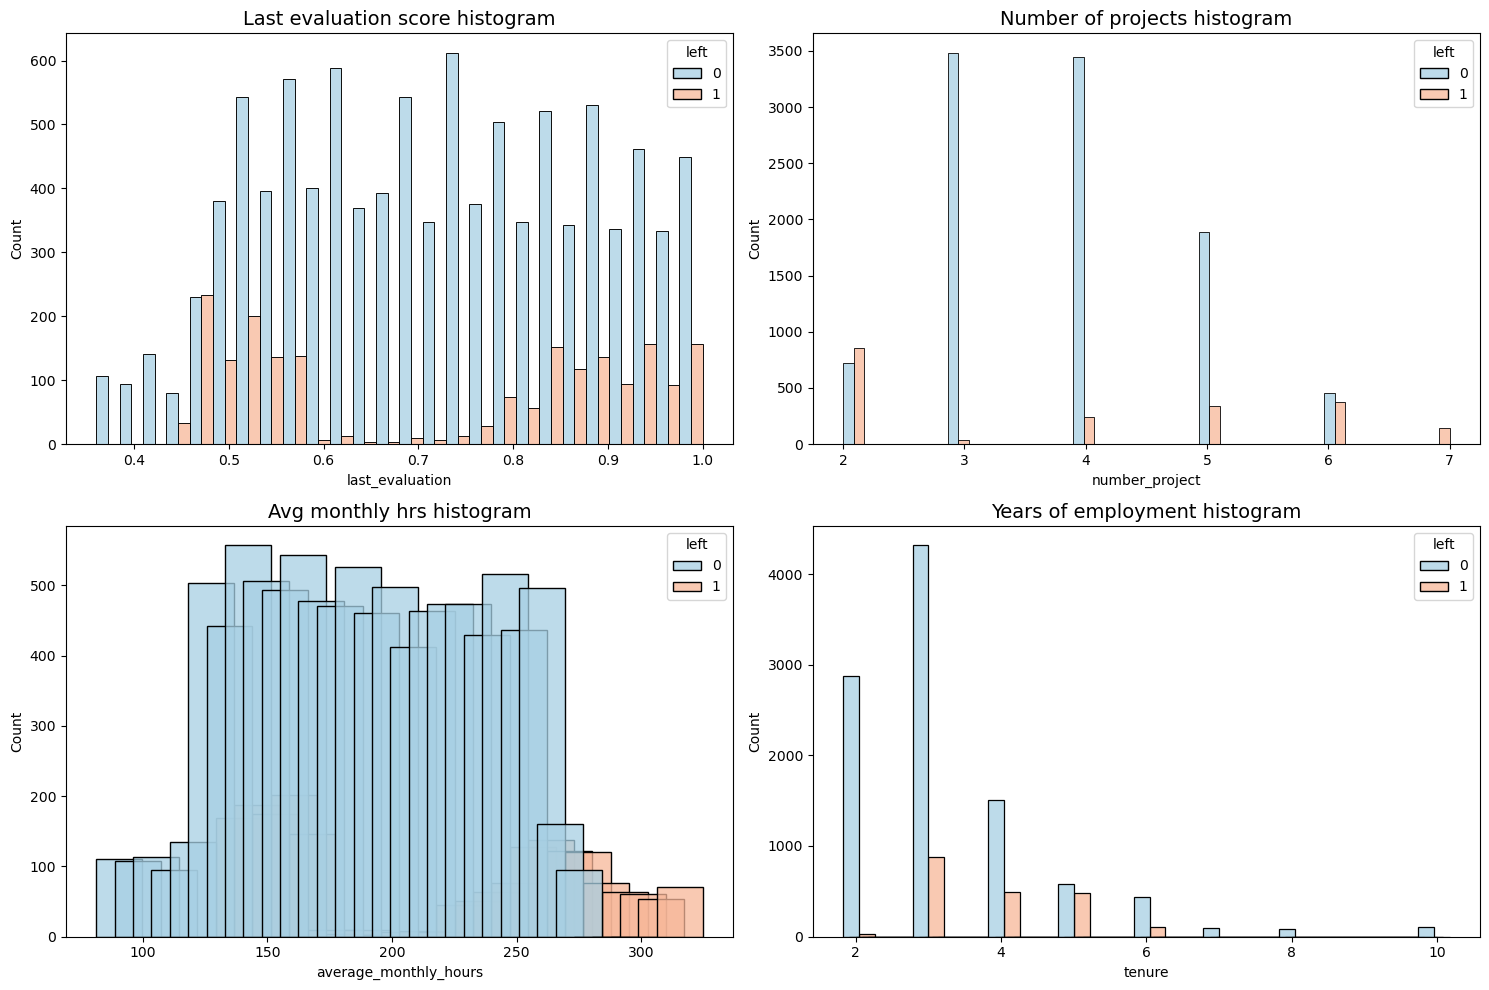

In [131]:
fig, ax = plt.subplots(2, 2, figsize = (15,10))

sns.histplot(df1, x='last_evaluation', hue='left', palette="RdBu_r", multiple='dodge', ax=ax[0,0])
ax[0,0].set_title('Last evaluation score histogram', fontsize='14')

sns.histplot(df1, x='number_project', hue='left', palette="RdBu_r", multiple='dodge', ax=ax[0,1])
ax[0,1].set_title('Number of projects histogram', fontsize='14')

sns.histplot(df1, x='average_monthly_hours', hue='left', palette="RdBu_r", multiple='dodge', shrink=5, ax=ax[1,0])
ax[1,0].set_title('Avg monthly hrs histogram', fontsize='14')

sns.histplot(df1, x='tenure', hue='left', palette="RdBu_r", multiple='dodge', shrink=5, ax=ax[1,1])
ax[1,1].set_title('Years of employment histogram', fontsize='14')


fig.tight_layout()
plt.show()


Ok, what we see above:
- Last evaluation - strange, there is more condensation of people who left around 0.5 and above 0.85 evaluation. People who left and got high evaluation might be the same people who had multiple projects and was working a great amount of hours.
- Number of projects - a no-brainer. The more projects you have, the more you tend to leave the company. No one wants to sacrifice life for work. Worth noticing that if you have 7 projects it is sure you'll leave the company. Interestingly people who work on 3 projects tend to not leave the company at all.
- Average hours - in plain sight - if you work more than ~280 hours per month you'll leave the company sooner or later.
- Years of employment (tenure) - there is a great risk of leaving in a 5-year group of people. It is an interesting conclusion and it's worth investigating further. What is more, after 6 years of employment there is almost no leaving from the company.


It might be worth comparing monthly hours with a number of projects divided into leaving factors:

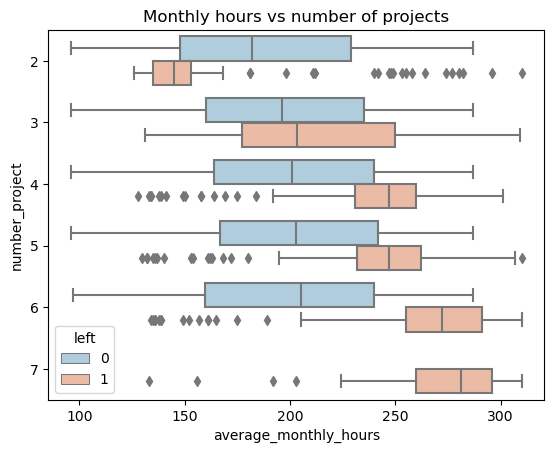

In [132]:
sns.boxplot(df1, x='average_monthly_hours', y='number_project', hue='left', palette="RdBu_r", orient="h")
plt.title('Monthly hours vs number of projects')

plt.show()

Now we see that:
- looking at medians - the more projects you have the more hours you work
- in the upper left-hand corner and lower right-hand corner those are two interesting groups who left the company: those who were working considerably fewer hours on projects than others (probably because of their notice) and hard-working people who left the company eventually
- there is only one case in which people in this company seem to follow a work-life balance: for people who stayed in the company and were working on 2 projects the median is ~160hours which is 8 hours per day

How do average monthly hours look in comparison to satisfaction level?

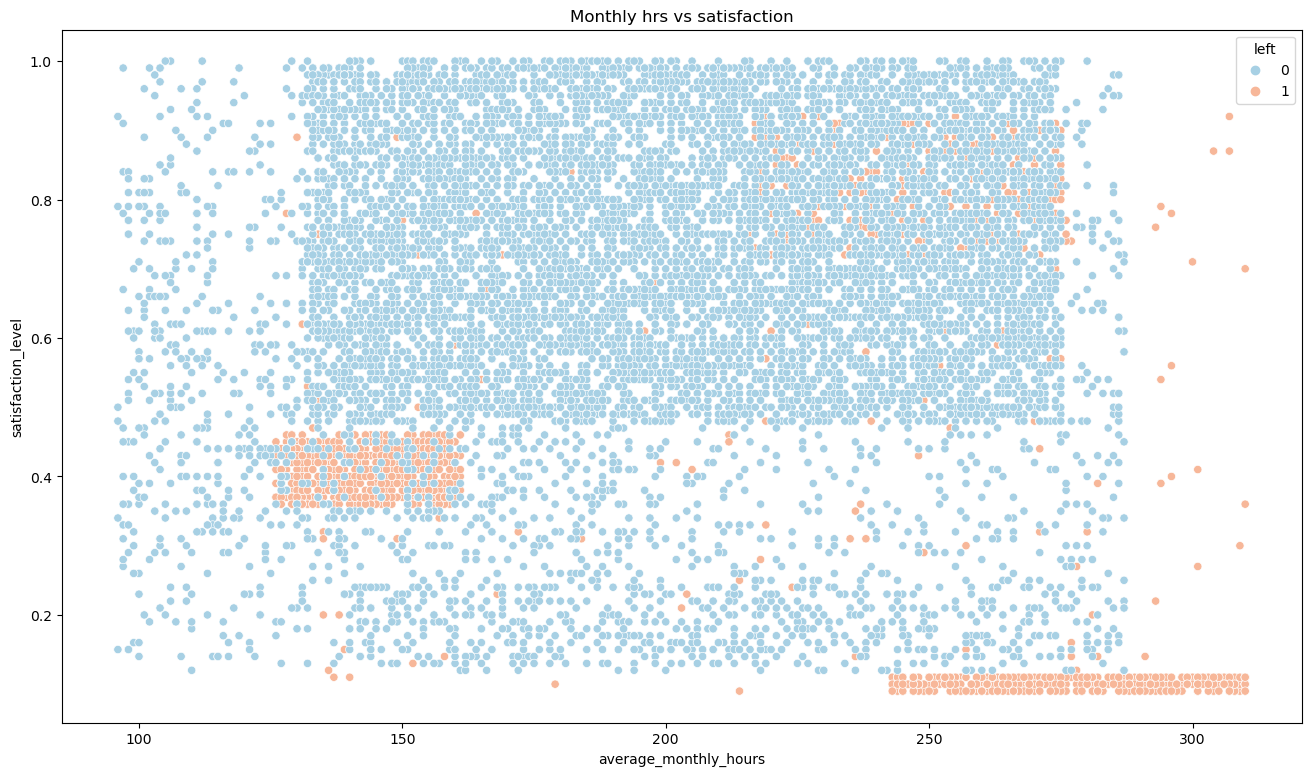

In [133]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', palette="RdBu_r")

plt.title('Monthly hrs vs satisfaction')

plt.show()

3 distinguishable groups of people left the company:
1. Upper right-hand corner - people who were working a tremendous amount of hours and had high satisfaction.
2. Lower right-hand corner - people who were working a great amount of hours and had super low satisfaction. No surprise that they left the company.
3. People with satisfaction around 0.4 and average hours around 140 - the most interesting case. Usual hours and low satisfaction. Might be a couple of reasons - may be low ambitious work? Maybe they felt not so good with the pressure and seeing other colleagues working way above 8 hours per day?

Gentlemen do not talk about money. But let's face it - we like to talk about them. Is there something unusual in salary distribution in comparison to the number of projects?

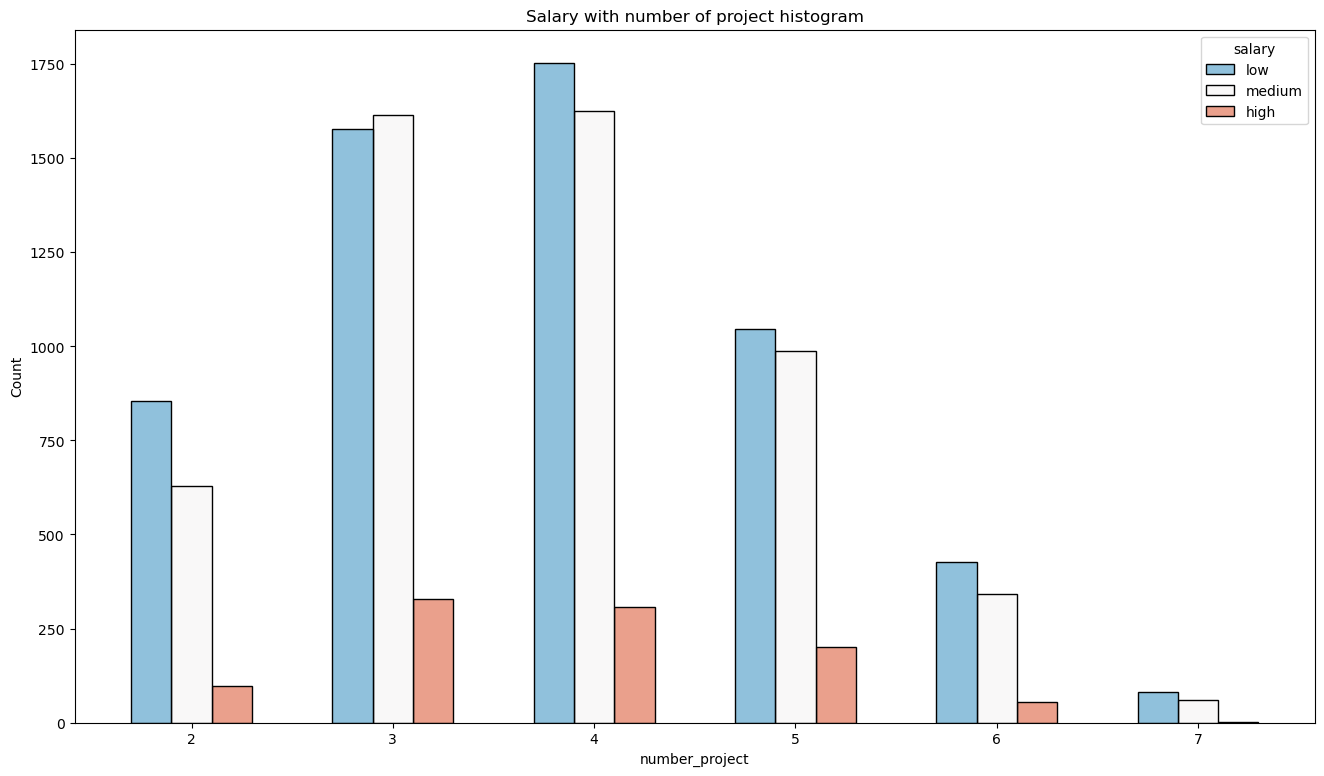

In [134]:
plt.figure(figsize=(16, 9))

sns.histplot(df1, x='number_project', hue='salary', palette="RdBu_r", discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.6)

plt.title('Salary with number of project histogram')
plt.show()

There is nothing unusual here. In every group, the proportion of low and medium salaries seems to be equal while high salary is only for a small portion of employees in each group.

Ok at the end let's find out if we have spoiled departments where people do not want to work and tend to quit more often in comparison to the rest of the company. 

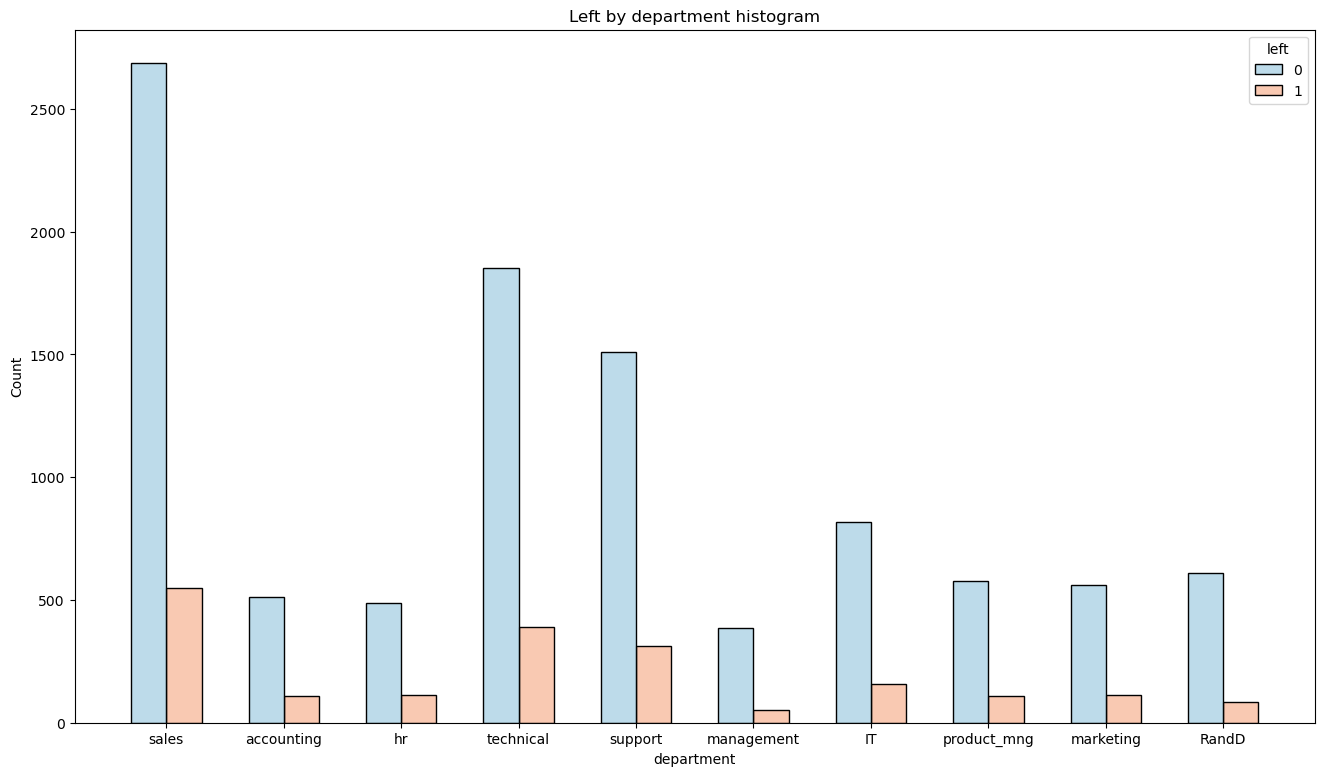

In [135]:
plt.figure(figsize=(16, 9))

sns.histplot(data=df1, x='department', hue='left', palette="RdBu_r", discrete=1, multiple='dodge', shrink=.6)


plt.title('Left by department histogram')
plt.show()

Ok, nothing unusual here. No department seems to stand out in proportion to people staying to those who left.

### Conclusions & Insights

Looks like we have a very busy company here. It doesn't mean that this company is an employee-friendly place. The attention to organizing projects and caring for people might be beneficial. The way of working in this company must change. Leaving the company is correlated with working large amounts of hours and working on many projects at the same time.

Three topics require further investigation:
- What is happening in a group of people employed 4 and 5 years ago? - the percentage of people who left in those groups is larger than in others
- Why percent of people leaving the company in people employed 6 years ago and earlier very low?
- What is the reason behind such a low percentage of promotion in the last 5 years? 2% seems to be low.

## Step 3. Model Building, Step 4. Results and Evaluation

All right. Here we go. In this section, I'll try to answer the question: what influences the most the employee's decision to leave the company?
It's a categorical variable (left) so that's a binary classification case. For this project I am going to build:
- Logistic Regression model
- Tree-based Machine Learning model


### Modeling Approach A: Logistic Regression Model


First things first:

In [136]:
df1.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
tenure                     int64
work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

As we see above we have 2 non-numeric variables (department and salary) so let's start the feature encoding process. 'department' is easy to proceed (get_dummies will do the work). In 'salary' we have categories so a dummy is not a good option. I'm going to change it into numbers.

In [137]:
df_encoded = df1.copy()

df_encoded['salary'] = (
    df_encoded['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

df_encoded = pd.get_dummies(df_encoded, drop_first=False)

df_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Ok looks fine. 

During EDA outliers were found (in tenure). As a reminder:

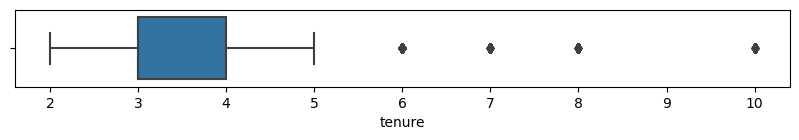

Upper limit: 5.5
Lower limit: 1.5


In [138]:
plt.figure(figsize=(10, 1))
sns.boxplot(x=df_encoded['tenure'])
plt.show()

print(f"Upper limit: {upper_limit}")
print(f"Lower limit: {lower_limit}")

Again, one of the logistic regression assumptions is "no extreme outliers". Let's remove them:

In [139]:
df_logistic =   df_encoded[
                        (df_encoded['tenure'] >= lower_limit) 
                        & 
                        (df_encoded['tenure'] <= upper_limit)
                        ]

It's time for isolating X and Y variable and splitting into training and testing sets:

In [140]:
#isolating
X = df_logistic.drop('left', axis=1)
y = df_logistic['left']

#splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

#of course it's 42, as almost every data science I follow that "The Hitchhiker's Guide to the Galaxy" trend :)

btw we have to use 'stratify' above because y is unbalanced:

In [141]:
df_logistic['left'].value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

**Finally construction of a model:**

In [142]:
logistic_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

Use the model to get predictions on **test** set:

In [143]:
y_pred = logistic_clf.predict(X_test)

A picture is worth a thousand words - let's see the results of the model on the confusion matrix:

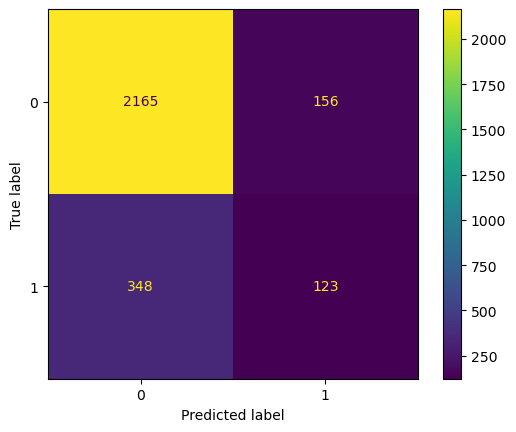

In [144]:
logistic_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

logistic_disp = ConfusionMatrixDisplay(confusion_matrix=logistic_cm, display_labels=log_clf.classes_)

logistic_disp.plot();

To understand and interpret the numbers in the above confusion matrix, it is important to keep the following in mind:

- The upper-left quadrant displays the number of **true negatives**.
- The bottom-left quadrant displays the number of **false negatives**.
- The upper-right quadrant displays the number of **false positives**.
- The bottom-right quadrant displays the number of **true positives**.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

So we have:
- 2165 people who didn't leave and the model predicted that
- 348 people left and the model predicted that they stayed
- 156 people who didn't leave and the model predicted that they left
- 123 people left and the model predicted that
    

And finally let's take a look at classification report:

In [145]:
print(classification_report(y_test, y_pred, target_names=['predicted not leave', 'predicted leve']))

                     precision    recall  f1-score   support

predicted not leave       0.86      0.93      0.90      2321
     predicted leve       0.44      0.26      0.33       471

           accuracy                           0.82      2792
          macro avg       0.65      0.60      0.61      2792
       weighted avg       0.79      0.82      0.80      2792



Logistic regression model achieved: precision - 79%, recall - 82%, f1-score - 80%.

Since we are aiming to predict employees who leave, the most important measure is Recall (the proportion of data points that are predicted as True, out of all the data points that are actually True).

And let's look at ROC curve:

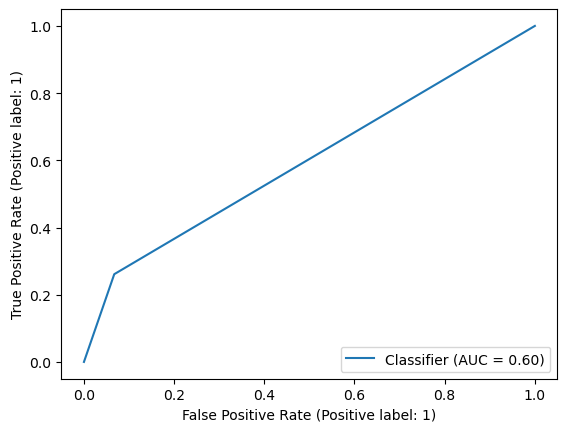

In [146]:
RocCurveDisplay.from_predictions(y_test, y_pred);

In [147]:
roc_auc_score(y_test,y_pred)

0.5969670441853253

The more that the ROC curve hugs the top left corner of the plot, the better the model does at classifying the data.

As a reminder:
AUC stands for the area under the ROC curve. AUC ranges from 0 to 1.
An AUC smaller than 0.5 indicates that the model performs worse than a random classifier (i.e. a classifier that randomly assigns each example to True or False), and an AUC larger than 0.5 indicates that the model performs better than a random classifier.

### Modeling Approach B: Tree-based Model

Isolate X and Y variable and splitting into training and testing sets:

In [148]:
X = df_encoded.drop('left', axis=1)
y = df_encoded['left']

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree - Round 1

In [149]:
# Instantiate
decision_tree = DecisionTreeClassifier(random_state=0)

# Dictionary of hyperparameters
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

#scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(decision_tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the decision tree model to the training data.

In [150]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 3.31 s, sys: 93 ms, total: 3.41 s
Wall time: 3.44 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy', 'f1', 'roc_auc', 'recall', 'precision'})

Let's find out the best parameters:

In [151]:
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

And let's find the best AUC score:

In [152]:
tree1.best_score_

0.969819392792457

Nice! This model can predict if an employee will leave very well.

Lets take a look at decision tree splits:

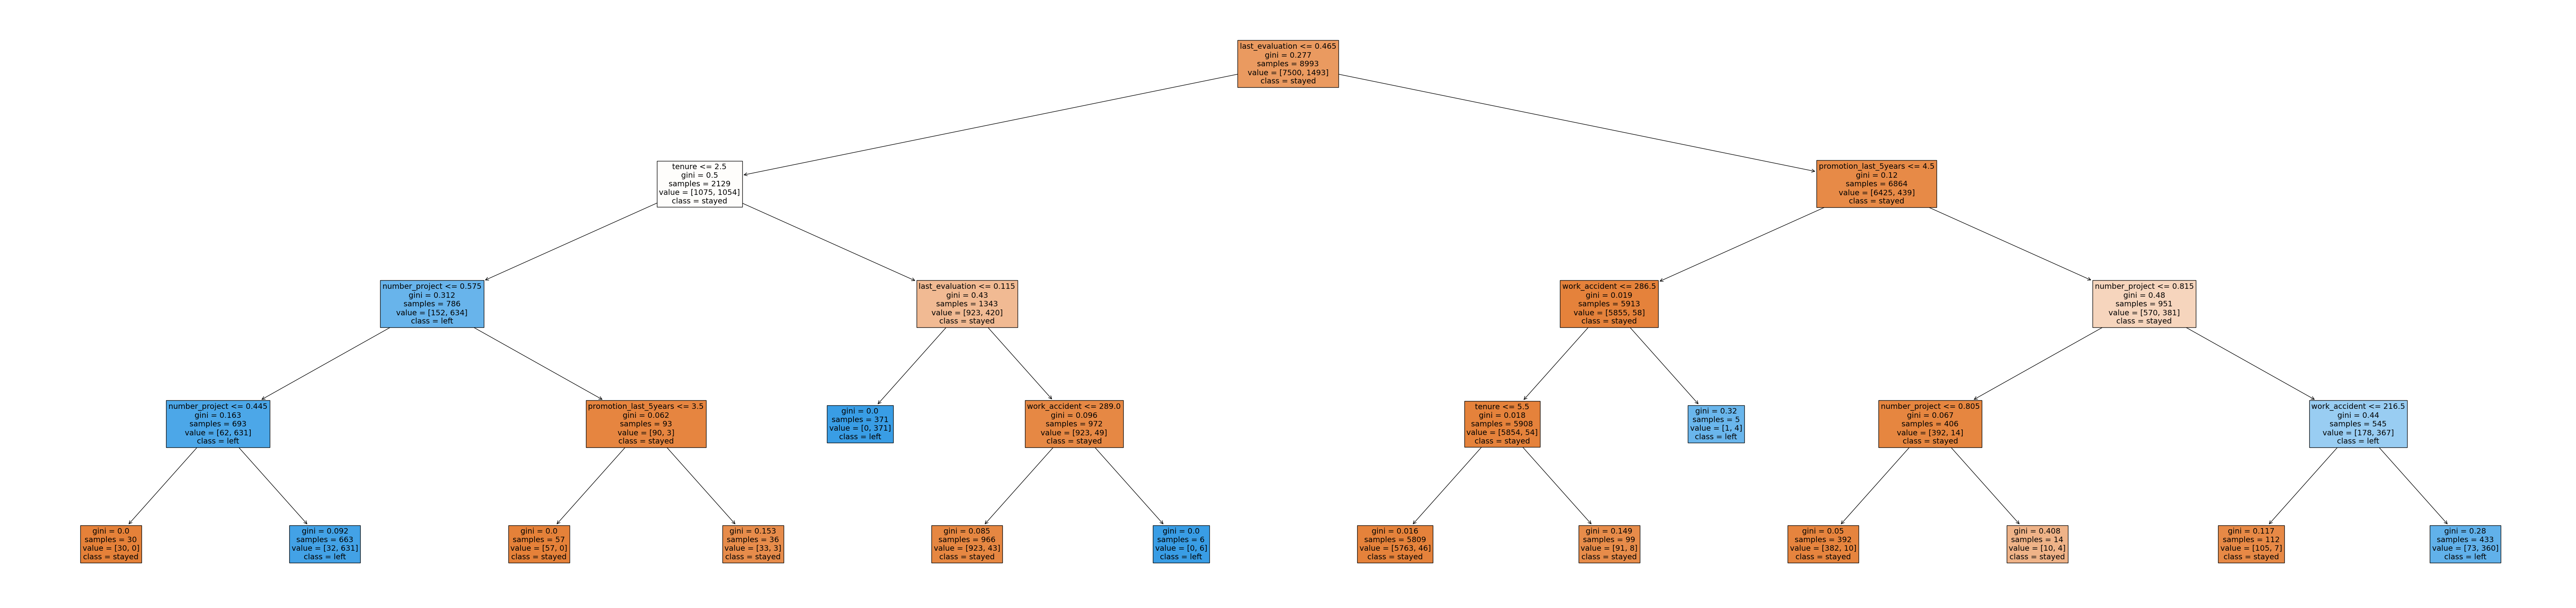

In [208]:
plt.figure(figsize=(85,20))
plot_tree(tree1.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

Next is the function for extracting scores in putting them into the table:

In [153]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

So let's use above function to grab all scores from the grid search: 

In [154]:
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.914552,0.916949,0.915707,0.971978,0.969819


These scores look very nice. This model works very well. Decision tree could end in overfitting, so let's try random forest to check if that's the case:

#### Random forest - Round 1

In [155]:
random_forest = RandomForestClassifier(random_state=0)

#dictionary of hyperparameters
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

#scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(random_forest, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the random forest model to the training data.

In [176]:
#%%time
#rf1.fit(X_train, y_train)

#it took 19 minutes; beware when de-commenting lines above :)

Save the model

In [165]:
path = '/Users/mck/Documents/na_tym_pracowac/'

Functions to pickle the model and read in the model

In [166]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [167]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

And let's use functions above:

In [168]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [169]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

Identify the best AUC score from random forest:

In [170]:
rf1.best_score_

0.9804250949807172

Also nice! And what about the best parameters?

In [171]:
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

Ok put that into score table:

In [173]:
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


Random forest works better than decision tree in this case (only recall and accuracy are comparable).

Let's chceck final model on test set. Function to get scores:

In [174]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

Now use the best performing model to predict on the **test set**.

In [175]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.964211,0.919679,0.941418,0.980987,0.956439


The scores above are similar to those before (from the training set). They are decent and it seems that this model is a very solid one.

## Feature Engineering

Feature engineering is often one of the best and easiest ways to boost model performance.

We know from the EDA that working overtime is a common practice in this company. Let's change the column **average_monthly_hours** from hours to just boolean information if the particular employee works over 8 hours a day (let's assume the threshold at 160 hours per month).

And let's drop the column **satisfaction_level**.

In [181]:
df2 = df_encoded.drop('satisfaction_level', axis=1)

df2['over_hours'] = (df2['average_monthly_hours'] > 160).astype(int)
df2 = df2.drop('average_monthly_hours', axis=1)

df2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,over_hours
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


Preparing dependent and independent variables plus splitting the data:

In [182]:
X = df2.drop('left', axis=1)
y = df2['left']

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

Since random forest gave better results, let's check only this one in second round.

#### Random forest - Round 2

In [183]:
random_forest = RandomForestClassifier(random_state=0)

#dictionary of hyperparameters
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

#scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf2 = GridSearchCV(random_forest, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [193]:
#%%time
#rf2.fit(X_train, y_train)
# processed in 15 mins

In [186]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')
rf2 = read_pickle(path, 'hr_rf2')

What are the best params?

In [187]:
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

And what was the best AUC score?

In [188]:
rf2.best_score_

0.9651698561072003

And put that into table:

In [230]:
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(rf2_cv_results)

#to compare 1st: random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425

               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.855557  0.874065  0.864655  0.954631  0.96517


Scores went down (probably because of the feature reduction we did) but still, we are around a solid value of 0.9 for every metric. The accuracy and AUC are slightly lower but again - very good nonetheless.

Predictions on **test** data:

In [198]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.840226,0.89759,0.867961,0.954636,0.931795


The results above are comparable to those obtained on the training set.

And how does a confusion matrix look like?

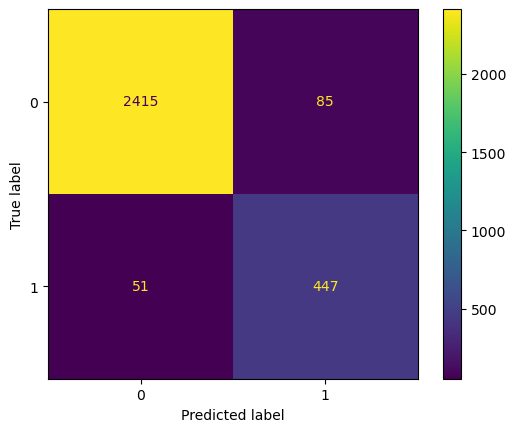

In [200]:
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf2.classes_)

disp.plot();

Random Forest round 2 predicted 85 people as those who will leave the company when they actually won't do that. That is not a big problem, because aiming this group HR department will probably take some actions, put campaigns into practice and so on. It will be a waste of money but that group is relatively small.

The model also predicted 51 people at no risk of leaving when they actually will leave. It means the model won't point at them and they will give notice sooner or later.
Still, this model is very strong, recall is around 0.9 and the number of that people is small.

### Feature importance

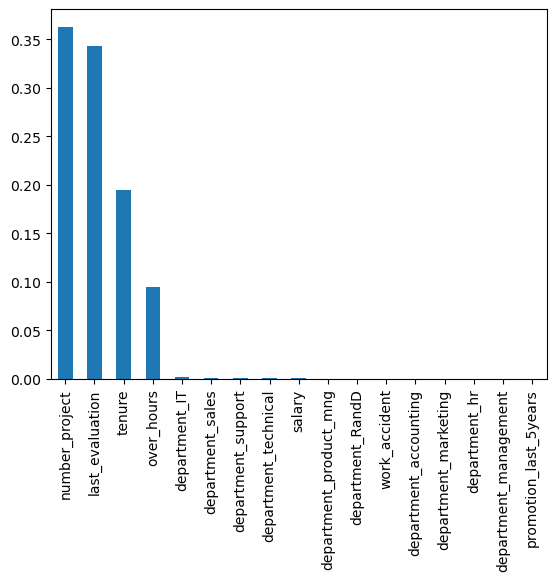

In [227]:
importances = rf2.best_estimator_.feature_importances_

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

When it comes to predicting whether the employee leave of not, the best variables to look at are:
- number of projects
- last evaluation score
- tenure
- is the employee work over 160 hours

## Step 5. Conclusions

### Summary of model results

**Logistic Regression**

The model resulted in:
precision 79%, recall 82%, f1-score 80%, accuracy 82%. The AUC score was 0.6

**Random forest**

In the second round of this model (after feature engineering - 'over_hours' was added) the results were:
precision 84%, recall 90%, f1 87%, accuracy 95%. The AUC score was 0.93



Based on the results above the random forest model was the better one.

### Conclusion

To recall the business need is: **"what’s likely to make the employee leave the company?"**.

People in Salifort Motors are overworked. The median monthly hours is 200 while it should be around 160.

After building a few models and investigating feature importance the main reasons people are leaving the company are:
- number of projects that employee concurrently works on
- last evaluation score
- tenure
- working over hours

Here are, based on the analysis, recommendations to improve employee retention:
- leaving is not connected with any particular department so it's a whole company problem
- employee should work on 3, max 4 projects at the same time
- investigate why do people work over hours - is that because of pressure? bad management? or unclear rules about how overtime is paid
- think about introducing with HR department work-life balance campaign
- conduct a further investigation about the reasons why people hired 4 and 5 years ago tend to leave the company; maybe conducting a questionnaire in this group will do the work?
- improve connection with the employees - maybe through regular 1on1 or feedback sessions manager-employee to know what employees are struggling